In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import re
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler

#### I'll load the customer data

In [2]:
def wrangle(filepath):
    df = pd.read_csv(filepath)
    
    return df

customer = wrangle('QVI_purchase_behaviour.csv')
customer

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream
...,...,...,...
72632,2370651,MIDAGE SINGLES/COUPLES,Mainstream
72633,2370701,YOUNG FAMILIES,Mainstream
72634,2370751,YOUNG FAMILIES,Premium
72635,2370961,OLDER FAMILIES,Budget


#### I'll load the transaction data

In [3]:
def wrangle(filepath):
    df = pd.read_excel(filepath)
    
    return df

transaction = wrangle('QVI_transaction_data.xlsx')
transaction

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8
...,...,...,...,...,...,...,...,...
264831,43533,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8
264832,43325,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4
264833,43410,272,272379,270187,51,Doritos Mexicana 170g,2,8.8
264834,43461,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8


In [4]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


#### In the customer dataset, there are no null values and the datatypes seem to be in order. We'll consider changing the datatype of the LYLTY_CARD_NBR column from integer to strings because it is an identifucation key for the loyalty cards and we don't need to carry out any calculations on it. Lastly, we'll also change the column names to lower case and make the  LYLTY_CARD_NBR column more descriptive. 

In [5]:
# Convert column names to lowercase
customer.columns = customer.columns.str.lower()

In [6]:
# Change the name of LYLTY_CARD_NBR column
customer = customer.rename(columns={'lylty_card_nbr': 'loyalty_card_num'})

In [7]:
# change loyalty_card_num to string
customer['loyalty_card_num'] = customer['loyalty_card_num'].astype(str)

In [8]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


#### Looks like there are no null values here too. However the date column seems out of place. We'll also be turning the STORE_NBR, PROD_NBR, LYLTY_CARD_NBR and TXN_ID to strings because they are identification numbers and we won't need to carry out any calculations on them. 

In [9]:
# Convert column names to lowercase
transaction.columns = transaction.columns.str.lower()

In [10]:
# Change the name of LYLTY_CARD_NBR column
transaction = transaction.rename(columns={'lylty_card_nbr': 'loyalty_card_num'})

In [11]:
# change loyalty_card_num, store_nbr and txn_id to string
transaction['loyalty_card_num'] = transaction['loyalty_card_num'].astype(str)
transaction['store_nbr'] = transaction['store_nbr'].astype(str)
transaction['txn_id'] = transaction['txn_id'].astype(str)
transaction['prod_nbr'] = transaction['prod_nbr'].astype(str)

#### The date column has a weird formatting. It turns out that it is formatted with an excel date. Hence, we'll be changing it to an appropriate date where we'll be getting the dates from the reference date: 1900-01-01

In [12]:
transaction['date'] = pd.to_datetime('1900-01-01') + pd.to_timedelta(transaction['date'] - 2, unit='D')

In [13]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   date              264836 non-null  datetime64[ns]
 1   store_nbr         264836 non-null  object        
 2   loyalty_card_num  264836 non-null  object        
 3   txn_id            264836 non-null  object        
 4   prod_nbr          264836 non-null  object        
 5   prod_name         264836 non-null  object        
 6   prod_qty          264836 non-null  int64         
 7   tot_sales         264836 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 16.2+ MB


#### The datatype of the date column has successfully changed to a datetime datatype. Now we'll be checking if the distinct values in some columns in both datasets are consistent before we merge them. 

In [14]:
# check the range of values in the lifestage column of customer table

distinct_values = customer['lifestage'].unique()
print(distinct_values)

['YOUNG SINGLES/COUPLES' 'YOUNG FAMILIES' 'OLDER SINGLES/COUPLES'
 'MIDAGE SINGLES/COUPLES' 'NEW FAMILIES' 'OLDER FAMILIES' 'RETIREES']


In [15]:
# check the range of values in the premium_customer column of customer table

distinct_values = customer['premium_customer'].unique()
print(distinct_values)

['Premium' 'Mainstream' 'Budget']


In [16]:
# check the range of values in the lifestage column of customer table

distinct_values = transaction['prod_name'].unique()
print(distinct_values)

['Natural Chip        Compny SeaSalt175g' 'CCs Nacho Cheese    175g'
 'Smiths Crinkle Cut  Chips Chicken 170g'
 'Smiths Chip Thinly  S/Cream&Onion 175g'
 'Kettle Tortilla ChpsHny&Jlpno Chili 150g'
 'Old El Paso Salsa   Dip Tomato Mild 300g'
 'Smiths Crinkle Chips Salt & Vinegar 330g'
 'Grain Waves         Sweet Chilli 210g'
 'Doritos Corn Chip Mexican Jalapeno 150g'
 'Grain Waves Sour    Cream&Chives 210G'
 'Kettle Sensations   Siracha Lime 150g' 'Twisties Cheese     270g'
 'WW Crinkle Cut      Chicken 175g' 'Thins Chips Light&  Tangy 175g'
 'CCs Original 175g' 'Burger Rings 220g'
 'NCC Sour Cream &    Garden Chives 175g'
 'Doritos Corn Chip Southern Chicken 150g' 'Cheezels Cheese Box 125g'
 'Smiths Crinkle      Original 330g'
 'Infzns Crn Crnchers Tangy Gcamole 110g'
 'Kettle Sea Salt     And Vinegar 175g'
 'Smiths Chip Thinly  Cut Original 175g' 'Kettle Original 175g'
 'Red Rock Deli Thai  Chilli&Lime 150g' 'Pringles Sthrn FriedChicken 134g'
 'Pringles Sweet&Spcy BBQ 134g' 'Red Rock 

#### Notice how the pack sizees and brand names are contained in most of the values. I'll be deriving it into another column

#### For the pack sizes, 'g' or 'G' is usually after it so we'll be using regular expression to extract it

In [17]:
# Write regular expression
pack_size_regex = r'(\d+)[gG]'

# Define a function to extract pack size from each item
def extract_pack_size(item):
    match = re.search(pack_size_regex, item)
    if match:
        return match.group(1)
    else:
        return None

# Apply the function to the 'item' column and create a new column 'pack_size'
transaction['pack_size_in_g'] = transaction['prod_name'].apply(lambda x: extract_pack_size(x))

#### It's going to be a bit difficult to extract the brand names because even though the brand names begin the values in the prod_name column, some brand names could have a single word while others could have multiple word. However, for the sake of consistencies, we'll be extracting only the first word after each space. 

In [18]:
# Define a function to extract the first word after the first space
def extract_brand_name(item):
    split_words = item.split()
    if len(split_words) > 1:
        brand_name = split_words[0].strip()
        return brand_name
    else:
        return None

# Apply the function to the 'brand_product_name' column and create a new column 'brand_name'
transaction['brand_name'] = transaction['prod_name'].apply(lambda x: extract_brand_name(x))

In [19]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   date              264836 non-null  datetime64[ns]
 1   store_nbr         264836 non-null  object        
 2   loyalty_card_num  264836 non-null  object        
 3   txn_id            264836 non-null  object        
 4   prod_nbr          264836 non-null  object        
 5   prod_name         264836 non-null  object        
 6   prod_qty          264836 non-null  int64         
 7   tot_sales         264836 non-null  float64       
 8   pack_size_in_g    264836 non-null  object        
 9   brand_name        264836 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(7)
memory usage: 20.2+ MB


In [20]:
# convert the pack_size_in_g to integer datatype
transaction['pack_size_in_g'] = transaction['pack_size_in_g'].astype(int)

In [21]:
# check the range of values in the lifestage column of customer table

distinct_values = transaction['tot_sales'].unique()
print(distinct_values)

[  6.     6.3    2.9   15.    13.8    5.1    5.7    3.6    3.9    7.2
  23.     9.2    1.7    3.3    2.1    3.     3.8    5.4    2.7    3.7
  14.8    4.4    6.6    2.6    3.25   4.6    5.8   15.5    7.8    4.2
   7.4    7.6    8.4    6.5    4.3   28.5    7.5    3.4   19.    11.8
  17.6    9.    13.2    1.9   10.2   13.    15.2   11.4   14.5    5.6
  10.8   10.4    1.5   16.5    1.8    5.2    5.9   18.4    8.8   18.5
   6.2    4.8    8.6    2.8    2.3    3.1    2.4   15.6   19.5   27.
   9.9   16.2   13.5   21.6   23.6   29.5   12.6    8.1   15.3   11.1
  22.     9.5   16.25  20.4   11.7   22.8    9.6    8.5   10.5   21.
  12.    14.4    9.75  16.8   25.5   17.7   17.2   17.1    4.5    6.8
  18.    12.9   11.5    8.7   14.    11.6   12.4  650.    21.5    9.3
  11.2    6.9 ]


#### Everything seems in place in the columns. The tot_sales column is also most likely to be measured in dollars but we won't be adding the unit in the column values so that it won't turn the column values to strings


#### Before we go one, let's remove the duplicates

In [22]:
# Remove duplicates from customer column
customer.drop_duplicates(inplace=True)

In [23]:
# Remove duplicates from transaction column
transaction.drop_duplicates(inplace=True)

#### Now let's merge both dataframes

#### We'll be using the default inner join because to get the customer segment we need their transactional data too so any loyalty card that hasn't been used by a customer is left out in this case. We'll need matching values from both dataframes

In [24]:
# Merge transaction and customer data on the loyalty_card_num columns
df = pd.merge(customer, transaction, on='loyalty_card_num')

In [25]:
df

,loyalty_card_num,lifestage,premium_customer,date,store_nbr,txn_id,prod_nbr,prod_name,prod_qty,tot_sales,pack_size_in_g,brand_name
0,1000,YOUNG SINGLES/COUPLES,Premium,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,Natural
1,1002,YOUNG SINGLES/COUPLES,Mainstream,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,Red
2,1003,YOUNG FAMILIES,Budget,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,Grain
3,1003,YOUNG FAMILIES,Budget,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,Natural
4,1004,OLDER SINGLES/COUPLES,Mainstream,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WW
...,...,...,...,...,...,...,...,...,...,...,...,...
264830,2370701,YOUNG FAMILIES,Mainstream,2018-12-08,88,240378,24,Grain Waves Sweet Chilli 210g,2,7.2,210,Grain
264831,2370751,YOUNG FAMILIES,Premium,2018-10-01,88,240394,60,Kettle Tortilla ChpsFeta&Garlic 150g,2,9.2,150,Kettle
264832,2370961,OLDER FAMILIES,Budget,2018-10-24,88,240480,70,Tyrrells Crisps Lightly Salted 165g,2,8.4,165,Tyrrells
264833,2370961,OLDER FAMILIES,Budget,2018-10-27,88,240481,65,Old El Paso Salsa Dip Chnky Tom Ht300g,2,10.2,300,Old


#### Next, let's rearrange the order of the columns while selecting the relevant ones. We'll be leaving the txn_id and prod_nbr behind because they are not relevant

In [26]:
# Define the desired column order
column_order = ['date', 'lifestage', 'premium_customer', 'loyalty_card_num', 'store_nbr', 'prod_name', 'pack_size_in_g', 'brand_name',\
                'prod_qty', 'tot_sales']
                

# Rearrange the columns in the dataset
df = df[column_order]

In [27]:
df

,date,lifestage,premium_customer,loyalty_card_num,store_nbr,prod_name,pack_size_in_g,brand_name,prod_qty,tot_sales
0,2018-10-17,YOUNG SINGLES/COUPLES,Premium,1000,1,Natural Chip Compny SeaSalt175g,175,Natural,2,6.0
1,2018-09-16,YOUNG SINGLES/COUPLES,Mainstream,1002,1,Red Rock Deli Chikn&Garlic Aioli 150g,150,Red,1,2.7
2,2019-03-07,YOUNG FAMILIES,Budget,1003,1,Grain Waves Sour Cream&Chives 210G,210,Grain,1,3.6
3,2019-03-08,YOUNG FAMILIES,Budget,1003,1,Natural ChipCo Hony Soy Chckn175g,175,Natural,1,3.0
4,2018-11-02,OLDER SINGLES/COUPLES,Mainstream,1004,1,WW Original Stacked Chips 160g,160,WW,1,1.9
...,...,...,...,...,...,...,...,...,...,...
264830,2018-12-08,YOUNG FAMILIES,Mainstream,2370701,88,Grain Waves Sweet Chilli 210g,210,Grain,2,7.2
264831,2018-10-01,YOUNG FAMILIES,Premium,2370751,88,Kettle Tortilla ChpsFeta&Garlic 150g,150,Kettle,2,9.2
264832,2018-10-24,OLDER FAMILIES,Budget,2370961,88,Tyrrells Crisps Lightly Salted 165g,165,Tyrrells,2,8.4
264833,2018-10-27,OLDER FAMILIES,Budget,2370961,88,Old El Paso Salsa Dip Chnky Tom Ht300g,300,Old,2,10.2


#### Now let's get on to the exploratory data analysis

## Exploratory Data Analysis

## Univariate Analysis

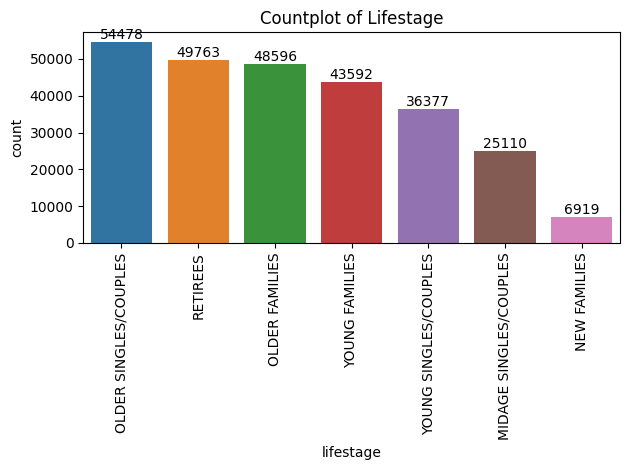

In [28]:
# visualize the counts of lifestage column
sorted_lifestage = df['lifestage'].value_counts().sort_values(ascending=False)

sns.countplot(data=df, x='lifestage', order=sorted_lifestage.index)

plt.title('Countplot of Lifestage')
plt.xticks(rotation=90)

# Adding data labels
for i, count in enumerate(sorted_lifestage):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

#### There's no wide gap between the first four categories that patronize the supermarket. However, older singles/couples patronize the store the most. 

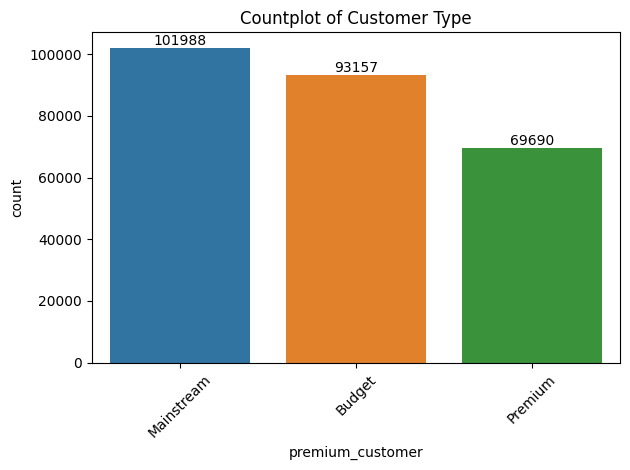

In [29]:
# visualize the counts of premium_customer column
sorted_premium_customer = df['premium_customer'].value_counts().sort_values(ascending=False)

sns.countplot(data=df, x='premium_customer', order=sorted_premium_customer.index)

plt.title('Countplot of Customer Type')
plt.xticks(rotation=45)

# Adding data labels
for i, count in enumerate(sorted_premium_customer):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

#### According to the count plot, most customers are average customers that are less price-sensitive than the premium customers but may not be willing to pay for luxury. They pay for products that are reasonably priced and offer good value. The number of budget customers (customers that love cheap product) is so close to the number of mainstream customers so the revenue of the supermarket could be close to average

C:\Users\USER\AppData\Local\Temp\ipykernel_6672\3819013295.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day'] = df['date'].dt.day_name()


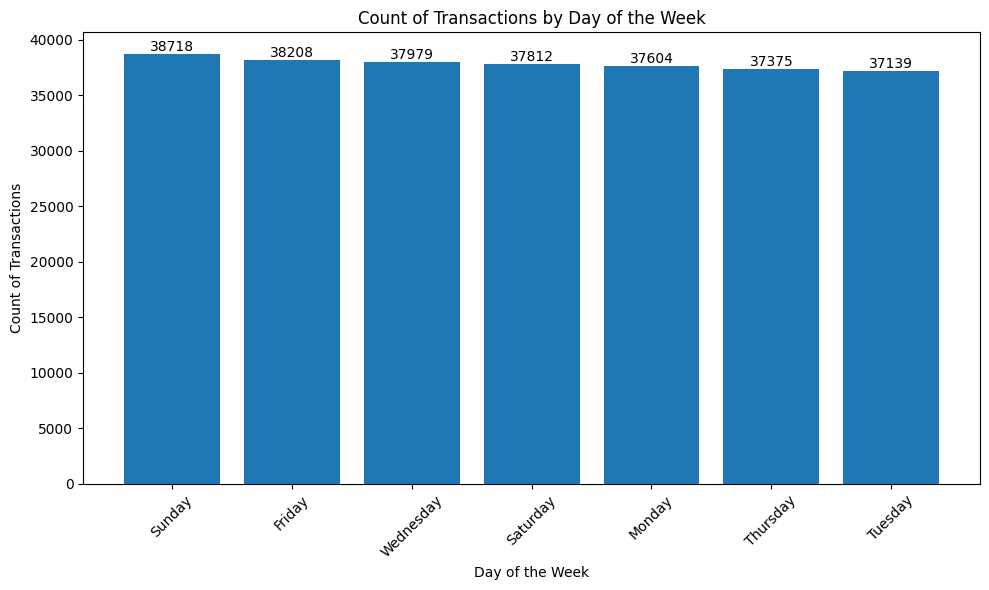

In [30]:
# Visualize transaction count by day

# Extract the day of the week from the date column
df['day'] = df['date'].dt.day_name()

# Group the transactions by day and get the count
transactions_by_day = df['day'].value_counts().sort_values(ascending=False)

# Plotting the count of transactions by day as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(transactions_by_day.index, transactions_by_day.values)
plt.xlabel('Day of the Week')
plt.ylabel('Count of Transactions')
plt.title('Count of Transactions by Day of the Week')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better visibility

# Adding data labels
for i, count in enumerate(transactions_by_day):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

#### According to this plot, we can't say there's a significant difference in the number of transactions by day

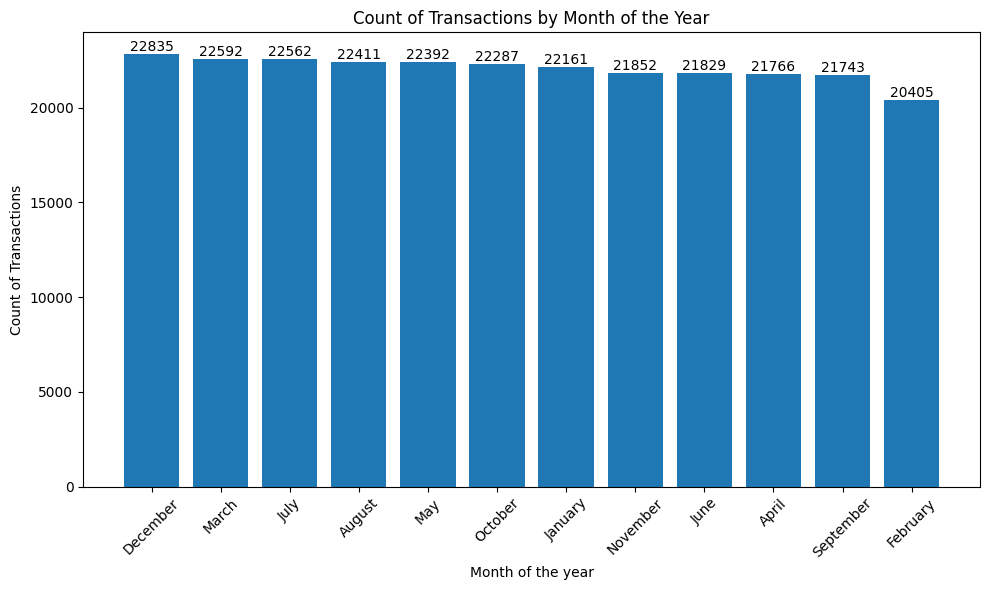

In [31]:
# Visualize transaction count by day

# Extract the day of the week from the date column
df['month'] = df['date'].dt.month_name()

# Group the transactions by day and get the count
transactions_by_month = df['month'].value_counts().sort_values(ascending=False)

# Plotting the count of transactions by day as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(transactions_by_month.index, transactions_by_month.values)
plt.xlabel('Month of the year')
plt.ylabel('Count of Transactions')
plt.title('Count of Transactions by Month of the Year')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better visibility

# Adding data labels
for i, count in enumerate(transactions_by_month):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

#### December had more sales but again, the difference isn't much from the other months

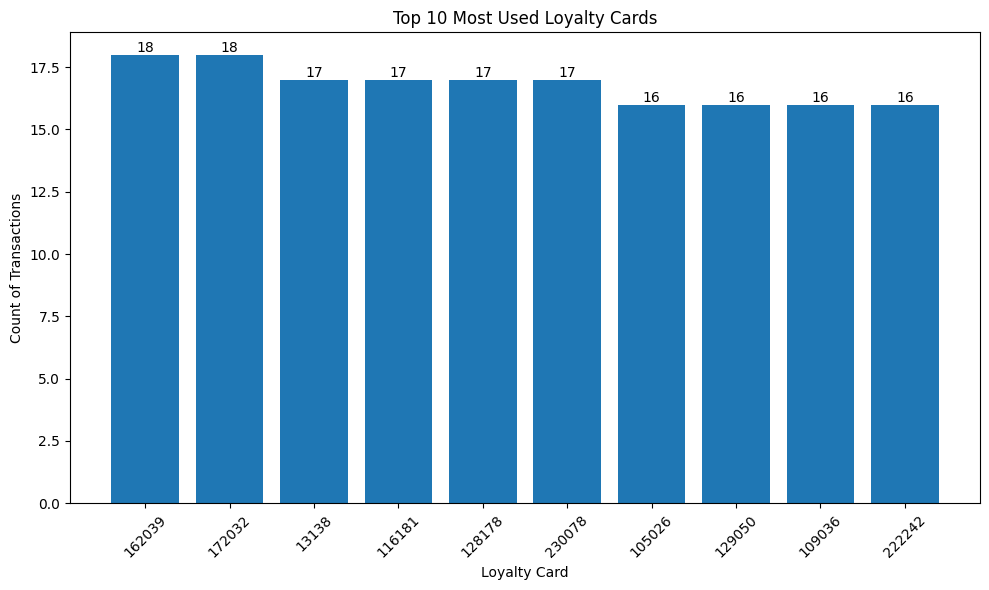

In [32]:
# visualize the loyalty card countplot
loyalty_card_counts = df['loyalty_card_num'].value_counts().head(10)

# Plotting the count of transactions by loyalty card as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(loyalty_card_counts.index, loyalty_card_counts.values)
plt.xlabel('Loyalty Card')
plt.ylabel('Count of Transactions')
plt.title('Top 10 Most Used Loyalty Cards')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better visibility

# Adding data labels
for i, count in enumerate(loyalty_card_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

#### The top 10 loyalty cards are really small in number compared to the total number of transactions in the data. This means the use of the loyalty cards is spread wide across and there's no particular card used by most customers

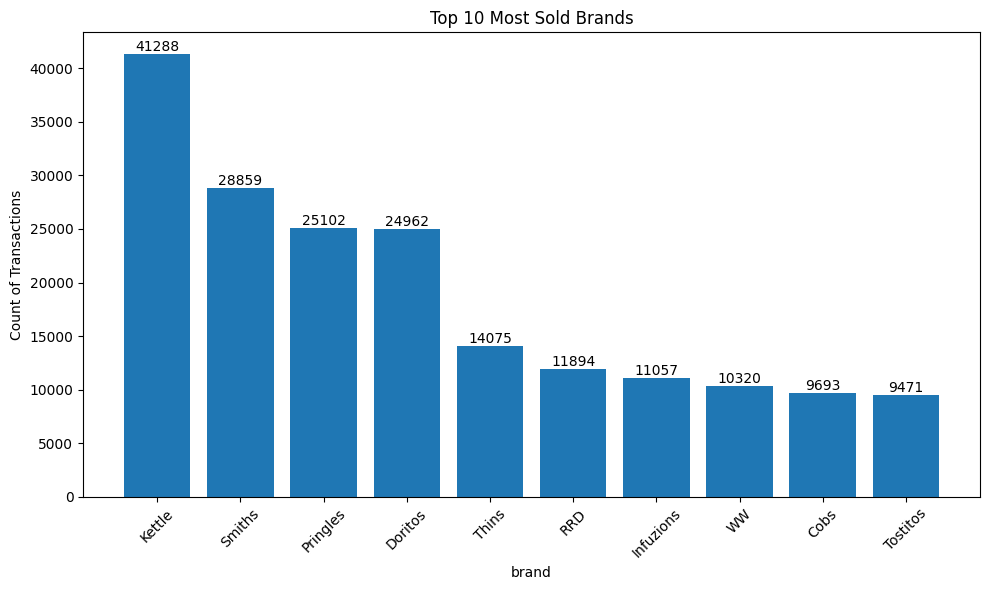

In [33]:
# visualize the most sold brands
brand_name_counts = df['brand_name'].value_counts().head(10)

# Plotting the count of transactions by loyalty card as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(brand_name_counts.index, brand_name_counts.values)
plt.xlabel('brand')
plt.ylabel('Count of Transactions')
plt.title('Top 10 Most Sold Brands')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better visibility

# Adding data labels
for i, count in enumerate(brand_name_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

#### Kettle is the most sold brand

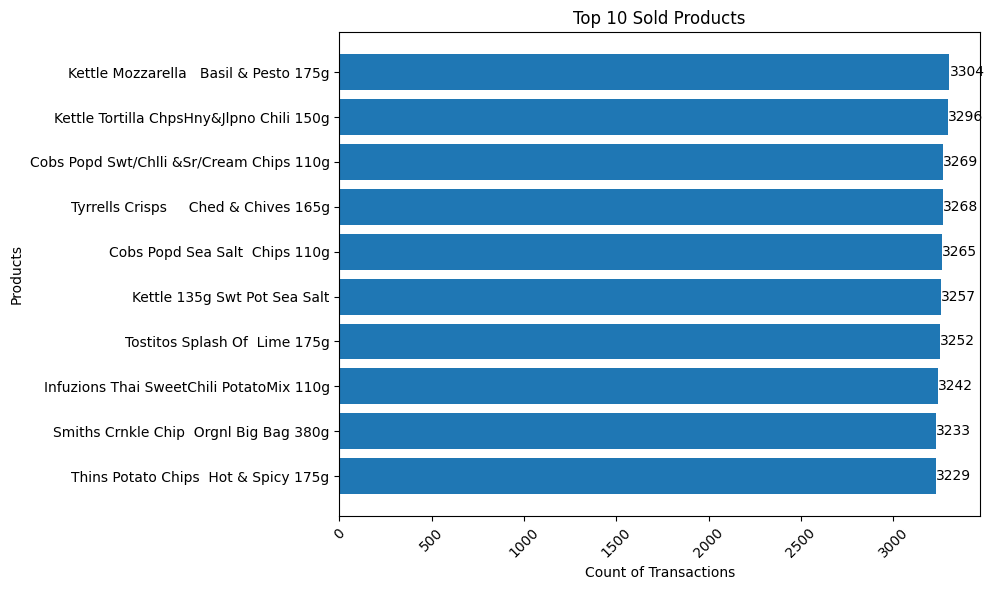

In [34]:
# visualize the top 10 sold products

# Group the transactions by product name and get the count
product_counts = df['prod_name'].value_counts().head(10).sort_values(ascending=True)

# Plotting the count of transactions by product name as a horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(product_counts.index, product_counts.values)
plt.ylabel('Products')
plt.xlabel('Count of Transactions')
plt.title('Top 10 Sold Products')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Adding data labels
for i, count in enumerate(product_counts):
    plt.text(count, i, str(count), ha='left', va='center')

plt.tight_layout()

plt.show()

#### These are the top sold products with little transaction differences between them

#### A major part of the supermarket customers buy products in singles. This could be because most of their customers still live alone

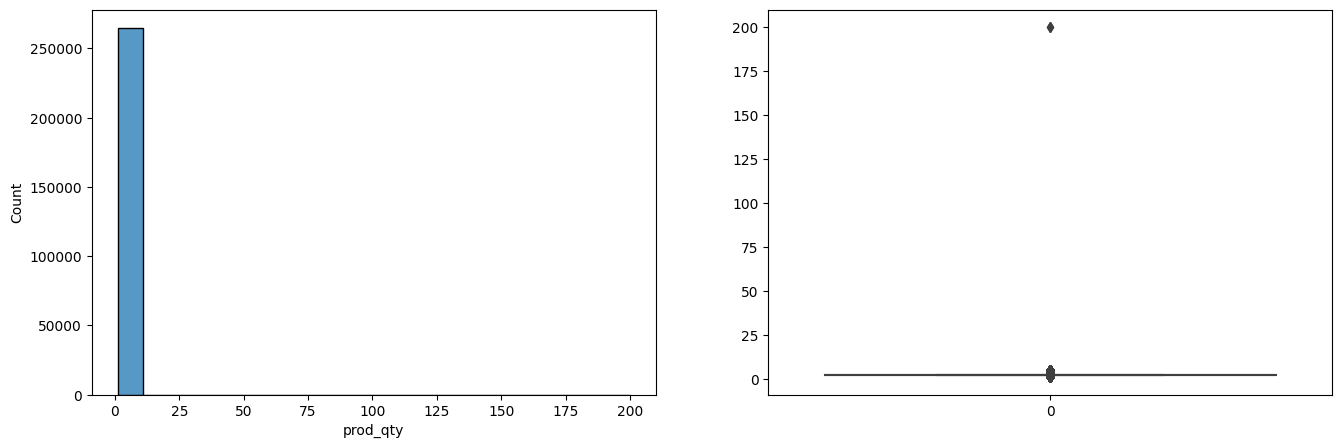

In [35]:
# distribution of product quantity
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.histplot(df['prod_qty'])
plt.subplot(1,2,2)
sns.boxplot(df['prod_qty'])
plt.show()

#### The distribution of this isn't clear because of the huge outlier. We'll handle the outliers later

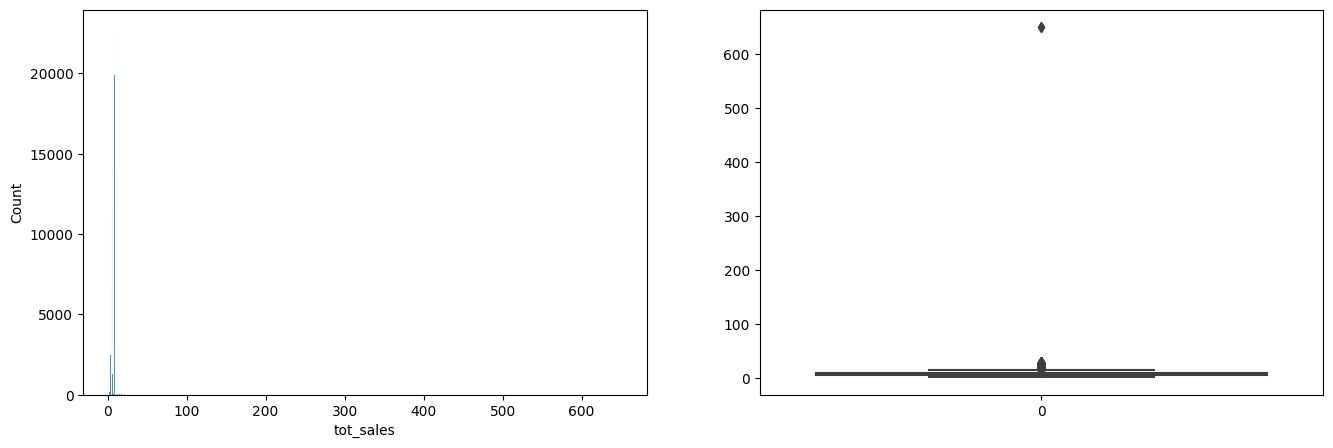

In [36]:
# distribution of product quantity
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.histplot(df['tot_sales'])
plt.subplot(1,2,2)
sns.boxplot(df['tot_sales'])
plt.show()

#### The distribution of this isn't also clear because of the huge outlier. We'll also handle the outliers later

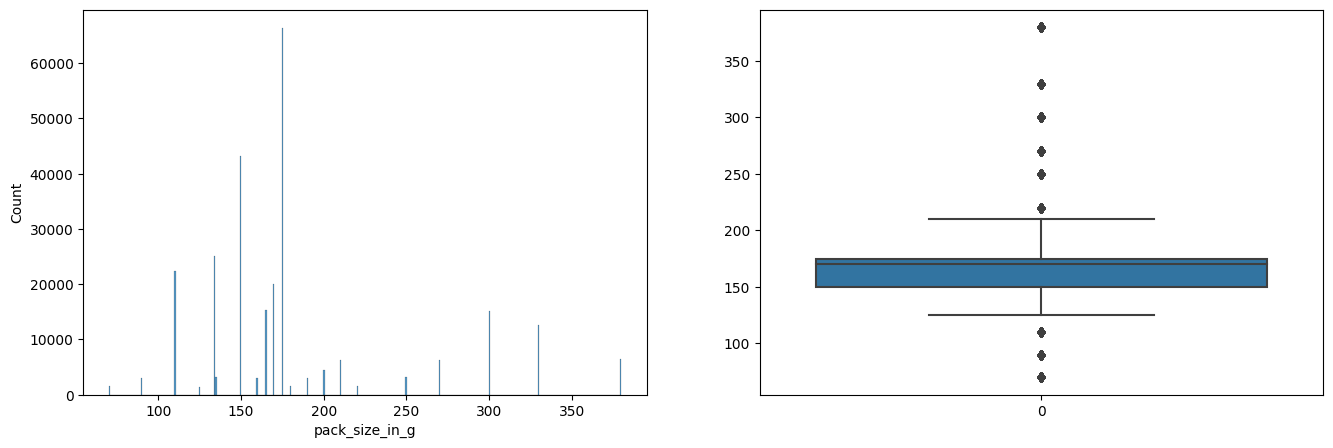

In [37]:
# visualize the distribution of the pack size column
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.histplot(df['pack_size_in_g'])
plt.subplot(1,2,2)
sns.boxplot(df['pack_size_in_g'])
plt.show()

#### There are outliers here and we'll be handling them later

## Bivariate Analysis

### What is the Lifestage by Revenue?

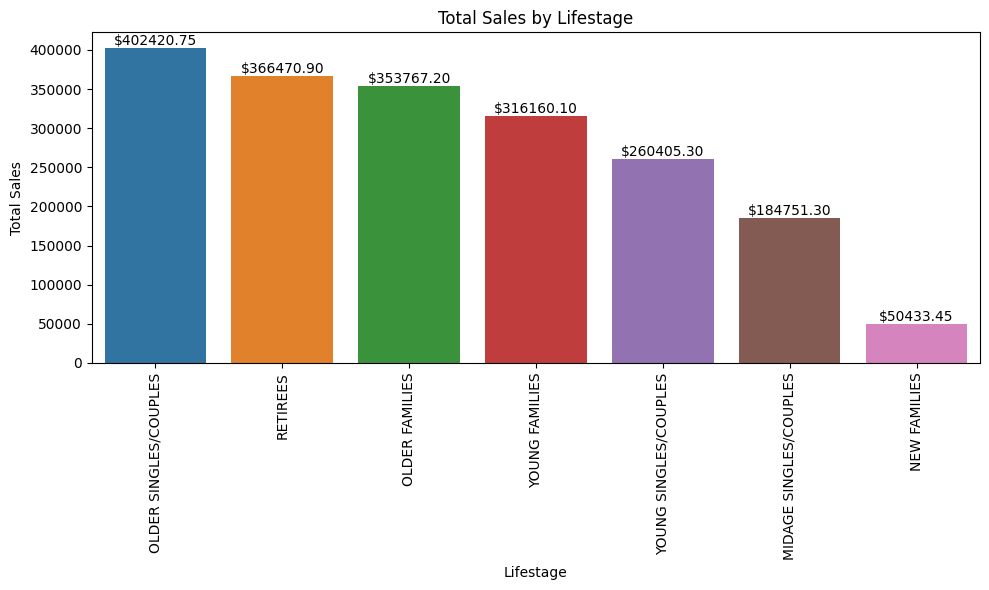

In [38]:
# Calculate total sales by lifestage
sales_by_lifestage = df.groupby('lifestage')['tot_sales'].sum().sort_values(ascending=False)

# Plotting total sales by lifestage as a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=sales_by_lifestage.index, y=sales_by_lifestage.values)
plt.xlabel('Lifestage')
plt.ylabel('Total Sales')
plt.title('Total Sales by Lifestage')
plt.xticks(rotation=90)

# Adding data labels
for i, sales in enumerate(sales_by_lifestage):
    plt.text(i, sales, f"${sales:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

#### Older singles/couples are bringing in more money into the business

### What is the Customer Type by Revenue?

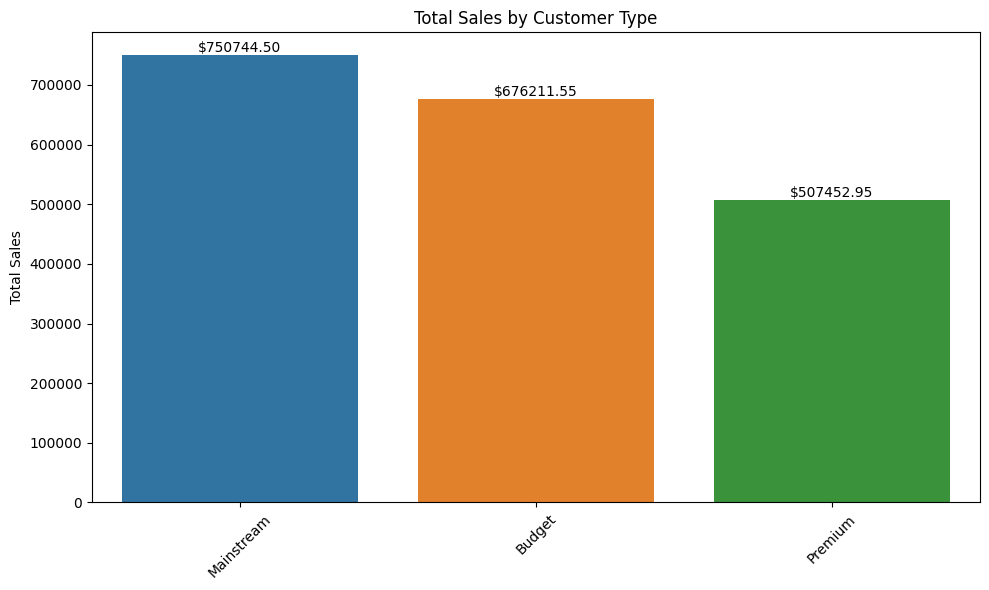

In [39]:
# Calculate total sales by customer type
sales_by_customer_type = df.groupby('premium_customer')['tot_sales'].sum().sort_values(ascending=False)

# Plotting total sales by lifestage as a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=sales_by_customer_type.index, y=sales_by_customer_type.values)
plt.xlabel('')
plt.ylabel('Total Sales')
plt.title('Total Sales by Customer Type')
plt.xticks(rotation=45)

# Adding data labels
for i, sales in enumerate(sales_by_customer_type):
    plt.text(i, sales, f"${sales:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

#### The Mainstream customers have brought in much money into the business

### What is the revenue by month?

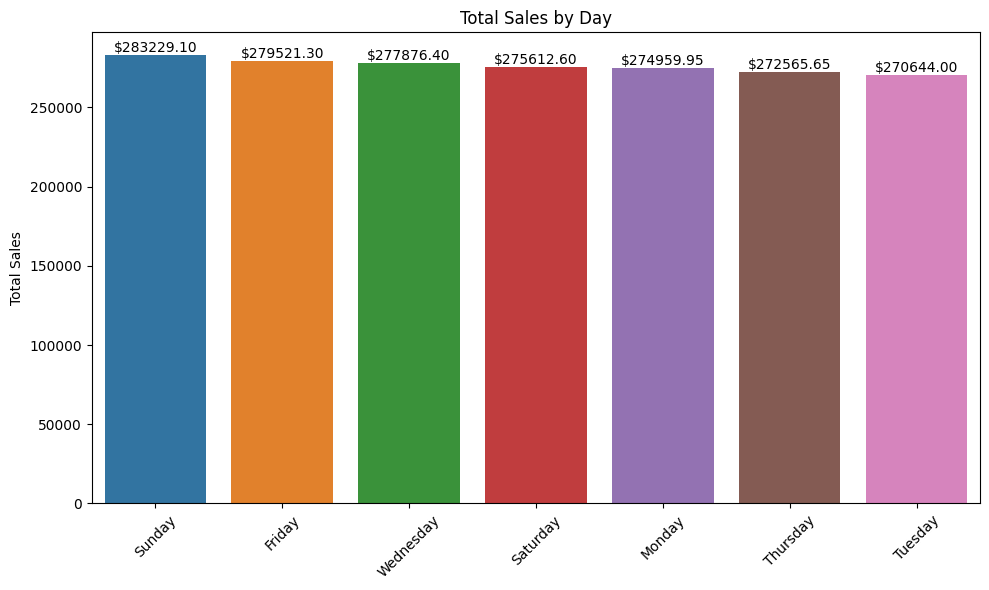

In [40]:
# Calculate total sales by customer type
sales_by_day = df.groupby('day')['tot_sales'].sum().sort_values(ascending=False)

# Plotting total sales by lifestage as a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=sales_by_day.index, y=sales_by_day.values)
plt.xlabel('')
plt.ylabel('Total Sales')
plt.title('Total Sales by Day')
plt.xticks(rotation=45)

# Adding data labels
for i, sales in enumerate(sales_by_day):
    plt.text(i, sales, f"${sales:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

#### The business usually makes more money on Sundays. This means that customers patronize them on outing days

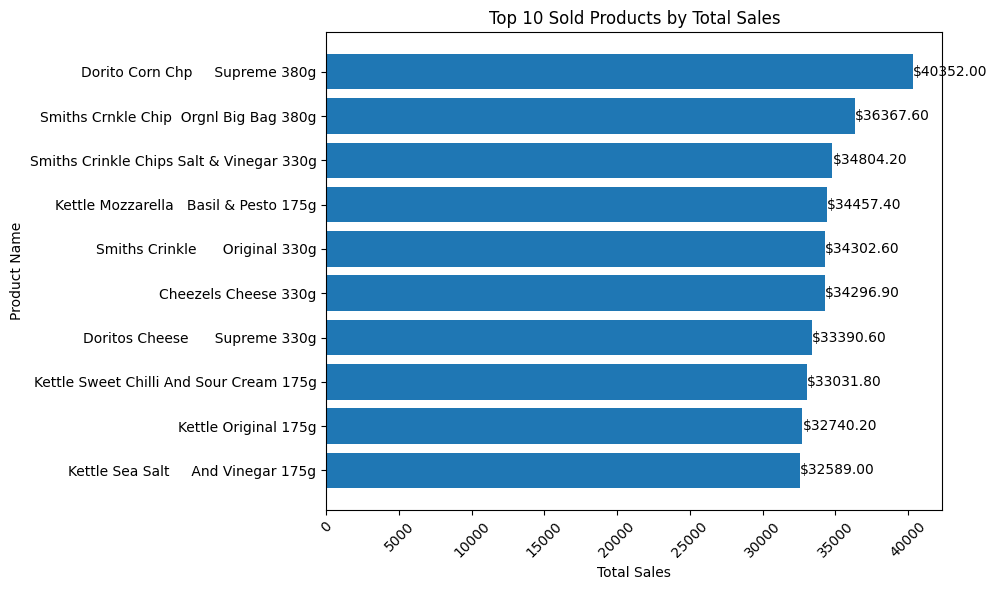

In [41]:
# Calculate total sales by product name
sales_by_products = df.groupby('prod_name')['tot_sales'].sum().nlargest(10).sort_values()

# Plotting total sales by product name as a horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(y=sales_by_products.index, width=sales_by_products.values)
plt.xlabel('Total Sales')
plt.ylabel('Product Name')
plt.title('Top 10 Sold Products by Total Sales')
plt.xticks(rotation=45)

# Adding data labels
for i, sales in enumerate(sales_by_products):
    plt.text(sales, i, f"${sales:.2f}", ha='left', va='center')

plt.tight_layout()
plt.show()

#### This is different from the top products by transaction count. Here, Dorito Corn Chip brought in much revenue to the company but Kettle Mozzarella Basil & Pesto that is the most sold product is the fourth product with highest revenue

### What is the Brand by Revenue?

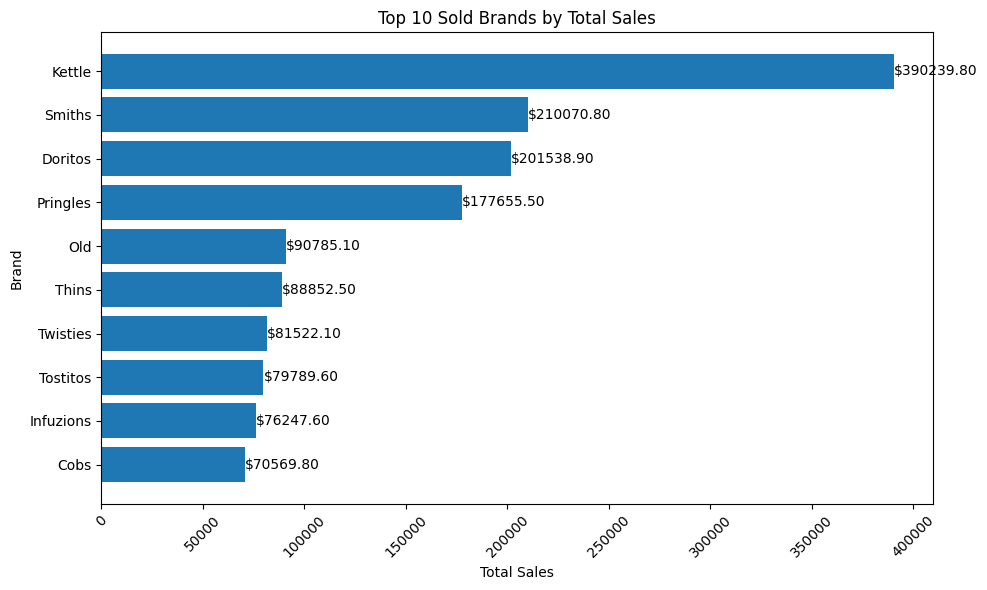

In [42]:
# Calculate total sales by product name
sales_by_brands = df.groupby('brand_name')['tot_sales'].sum().nlargest(10).sort_values()

# Plotting total sales by product name as a horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(y=sales_by_brands.index, width=sales_by_brands.values)
plt.xlabel('Total Sales')
plt.ylabel('Brand')
plt.title('Top 10 Sold Brands by Total Sales')
plt.xticks(rotation=45)

# Adding data labels
for i, sales in enumerate(sales_by_brands):
    plt.text(sales, i, f"${sales:.2f}", ha='left', va='center')

plt.tight_layout()
plt.show()

#### The Kettle brand is still bringing in so much money for the supermarket

### What is the General Average and Median revenue?

In [43]:
# Get the average of the tot_sales column
mean_sales = df['tot_sales'].mean().round(2)
# Print the mean of all votes
print("General Average Revenue:", mean_sales)
print('\n')

# Get the average of the votes column
median_sales = df['tot_sales'].median().round(2)
# Print the mean of all votes
print("General Median Revenue:", median_sales)

General Average Revenue: 7.3


General Median Revenue: 7.4


### What is the Average Revenue for Each Customer Type?

In [44]:
# show the average revenue by customer type

df1 = df.groupby('premium_customer')['tot_sales'].mean().round(2)
print(df1.sort_values(ascending=False))

premium_customer
Mainstream    7.36
Premium       7.28
Budget        7.26
Name: tot_sales, dtype: float64


#### The Mainstream customers spend the highest amount on average while budget spend the lowest amount on average

### What is the Average Revenue for Each Lifestage?

In [45]:
# show the average revenue by lifestage

df1 = df.groupby('lifestage')['tot_sales'].mean().round(2)
print(df1.sort_values(ascending=False))

lifestage
OLDER SINGLES/COUPLES     7.39
MIDAGE SINGLES/COUPLES    7.36
RETIREES                  7.36
NEW FAMILIES              7.29
OLDER FAMILIES            7.28
YOUNG FAMILIES            7.25
YOUNG SINGLES/COUPLES     7.16
Name: tot_sales, dtype: float64


#### As expected, the older singles/couples still spend the highest on average. However, the midage singles/couples and retireees surprisingly spends the same on average. It turns out that if the number of midage single/couples and new families increase, there could actually be more money for the business. 

## Multivariate Analysis

#### We'll be using ANOVA to find out if there are any differences between the categorical data in regards to the numerical data

In [46]:
categorical_columns = ['lifestage', 'premium_customer', 'day', 'month', 'prod_name', 'brand_name']
numerical_columns = df.select_dtypes(include=['float', 'int']).columns

# Iterate over the combinations of categorical and numerical variables to perform ANOVA
for cat_col in categorical_columns:
    for num_col in numerical_columns:
        group_labels = df[cat_col].unique()
        groups = [df[num_col][df[cat_col] == label] for label in group_labels]
        anova_result = stats.f_oneway(*groups)
        print(f"ANOVA p-value between {cat_col} and {num_col}: {anova_result.pvalue}")
    print("")

ANOVA p-value between lifestage and pack_size_in_g: 0.08415205854961838
ANOVA p-value between lifestage and prod_qty: 6.829747162753911e-203
ANOVA p-value between lifestage and tot_sales: 1.96293388581376e-32

ANOVA p-value between premium_customer and pack_size_in_g: 0.03578473609184926
ANOVA p-value between premium_customer and prod_qty: 0.0018622570402617162
ANOVA p-value between premium_customer and tot_sales: 1.8235974572557233e-13

ANOVA p-value between day and pack_size_in_g: 0.06367564217338767
ANOVA p-value between day and prod_qty: 0.23973218844183378
ANOVA p-value between day and tot_sales: 0.6189692181528099

ANOVA p-value between month and pack_size_in_g: 0.44905717602659867
ANOVA p-value between month and prod_qty: 6.1127078383652494e-93
ANOVA p-value between month and tot_sales: 2.591373420851284e-71



C:\Python39\lib\site-packages\scipy\stats\_stats_py.py:3895: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


ANOVA p-value between prod_name and pack_size_in_g: 0.0
ANOVA p-value between prod_name and prod_qty: 6.481689868021762e-13
ANOVA p-value between prod_name and tot_sales: 0.0

ANOVA p-value between brand_name and pack_size_in_g: 0.0
ANOVA p-value between brand_name and prod_qty: 2.0441037409739523e-30
ANOVA p-value between brand_name and tot_sales: 0.0



#### According to the ANOVA p-values, lifestage, premium_customer, day, prod_name, and brand_name varies alongside the pack_size_in_g. premium_customer only varies alonside the prod_qty which is obvious because the categories in premium_customer are judged based on the product quantities they purchase. prod_name and brand_name varies alongside tot_sales. This could mean that some brands are either highly sought after and/or expensive than the others.  

#### This means that the categorical  columns are all different in regards to the product quantity and the total sales. The p-value of the brand_name and prod_name when associated with the park_size_in_g column seems less than 0.01 most likely because the park_size_in_g was derived from the prod_name

#### Let's illustrate this with visualizations

C:\Users\USER\AppData\Local\Temp\ipykernel_6672\997676183.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df1 = df.groupby(by='premium_customer').agg("mean")[['prod_qty']].reset_index().sort_values(by='prod_qty', ascending=False)
C:\Users\USER\AppData\Local\Temp\ipykernel_6672\997676183.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(by='premium_customer').agg("mean")[['tot_sales']].reset_index().sort_values(by='tot_sales', ascending=False)


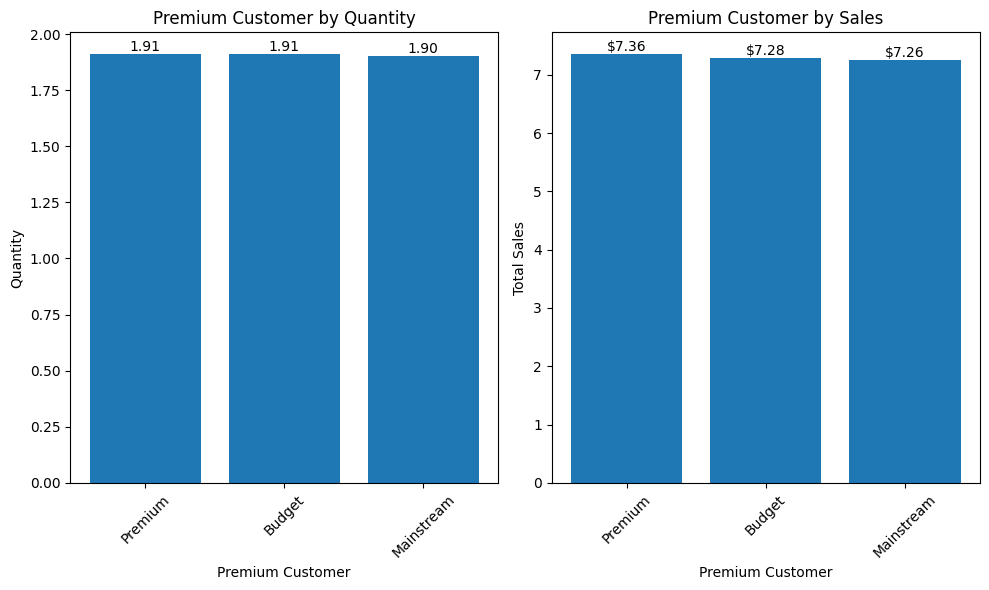

In [47]:
df1 = df.groupby(by='premium_customer').agg("mean")[['prod_qty']].reset_index().sort_values(by='prod_qty', ascending=False)
df2 = df.groupby(by='premium_customer').agg("mean")[['tot_sales']].reset_index().sort_values(by='tot_sales', ascending=False)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.bar(df1['premium_customer'], df1['prod_qty'])
plt.title('Premium Customer by Quantity')
plt.xlabel('Premium Customer')
plt.ylabel('Quantity')

# Adding data labels for prod_qty
for i, value in enumerate(df1['prod_qty']):
    plt.text(i, value, f"{value:.2f}", ha='center', va='bottom')

plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(df1['premium_customer'], df2['tot_sales'])
plt.title('Premium Customer by Sales')
plt.xlabel('Premium Customer')
plt.ylabel('Total Sales')

# Adding data labels for tot_sales
for i, value in enumerate(df2['tot_sales']):
    plt.text(i, value, f"${value:.2f}", ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### The visualizations show that the customer type are not so different in terms of the product quantity. However, the are different in terms of total sales

C:\Users\USER\AppData\Local\Temp\ipykernel_6672\3518412604.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df1 = df.groupby(by='lifestage').agg("mean")[['prod_qty']].reset_index().sort_values(by='prod_qty', ascending=False)
C:\Users\USER\AppData\Local\Temp\ipykernel_6672\3518412604.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(by='lifestage').agg("mean")[['tot_sales']].reset_index().sort_values(by='tot_sales', ascending=False)


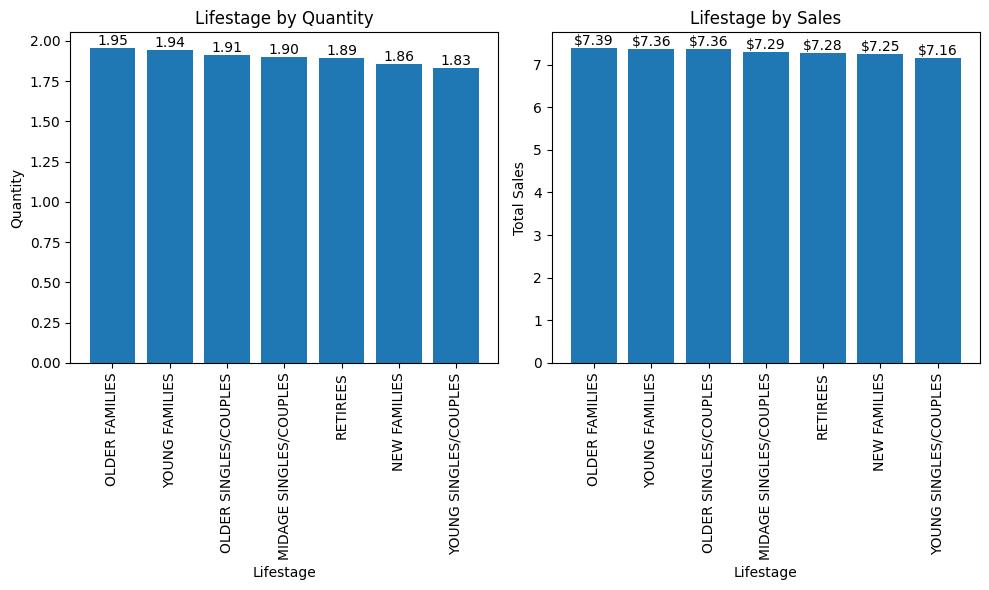

In [48]:
df1 = df.groupby(by='lifestage').agg("mean")[['prod_qty']].reset_index().sort_values(by='prod_qty', ascending=False)
df2 = df.groupby(by='lifestage').agg("mean")[['tot_sales']].reset_index().sort_values(by='tot_sales', ascending=False)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.bar(df1['lifestage'], df1['prod_qty'])
plt.title('Lifestage by Quantity')
plt.xlabel('Lifestage')
plt.ylabel('Quantity')

# Adding data labels for prod_qty
for i, value in enumerate(df1['prod_qty']):
    plt.text(i, value, f"{value:.2f}", ha='center', va='bottom')

plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
plt.bar(df1['lifestage'], df2['tot_sales'])
plt.title('Lifestage by Sales')
plt.xlabel('Lifestage')
plt.ylabel('Total Sales')

# Adding data labels for tot_sales
for i, value in enumerate(df2['tot_sales']):
    plt.text(i, value, f"${value:.2f}", ha='center', va='bottom')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#### in this case, the lifestage varies across product quantity and total sales

C:\Users\USER\AppData\Local\Temp\ipykernel_6672\1146096841.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df1 = df.groupby(by='day').agg("mean")[['prod_qty']].reset_index().sort_values(by='prod_qty', ascending=False)
C:\Users\USER\AppData\Local\Temp\ipykernel_6672\1146096841.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(by='day').agg("mean")[['tot_sales']].reset_index().sort_values(by='tot_sales', ascending=False)


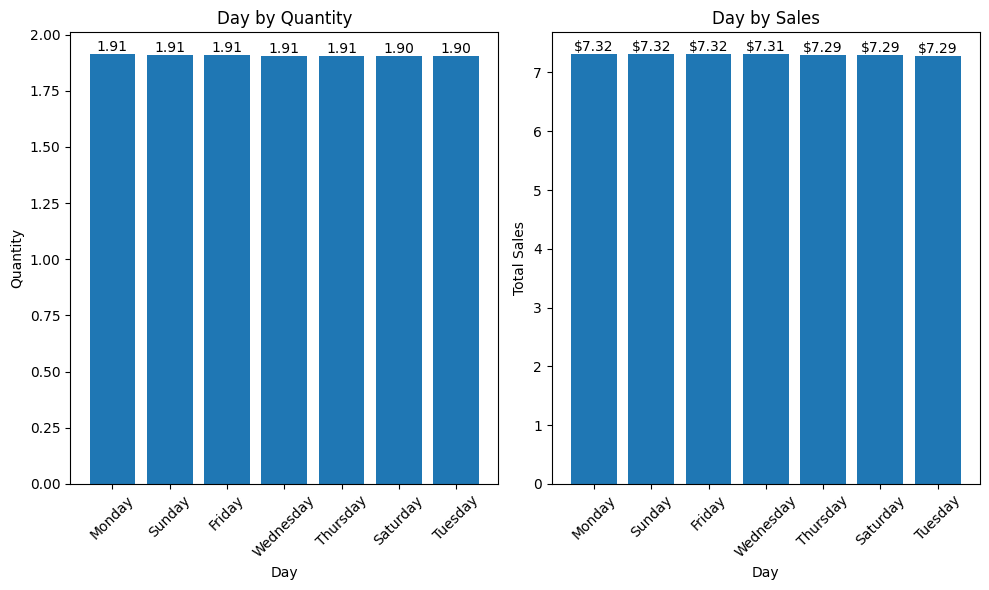

In [49]:
df1 = df.groupby(by='day').agg("mean")[['prod_qty']].reset_index().sort_values(by='prod_qty', ascending=False)
df2 = df.groupby(by='day').agg("mean")[['tot_sales']].reset_index().sort_values(by='tot_sales', ascending=False)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.bar(df1['day'], df1['prod_qty'])
plt.title('Day by Quantity')
plt.xlabel('Day')
plt.ylabel('Quantity')

# Adding data labels for prod_qty
for i, value in enumerate(df1['prod_qty']):
    plt.text(i, value, f"{value:.2f}", ha='center', va='bottom')

plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(df1['day'], df2['tot_sales'])
plt.title('Day by Sales')
plt.xlabel('Day')
plt.ylabel('Total Sales')

# Adding data labels for tot_sales
for i, value in enumerate(df2['tot_sales']):
    plt.text(i, value, f"${value:.2f}", ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### According to the visualizations, the days don't vary according to both the product quantity and the total sales

C:\Users\USER\AppData\Local\Temp\ipykernel_6672\444412644.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df1 = df.groupby(by='month').agg("mean")[['prod_qty']].reset_index().sort_values(by='prod_qty', ascending=False)
C:\Users\USER\AppData\Local\Temp\ipykernel_6672\444412644.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(by='month').agg("mean")[['tot_sales']].reset_index().sort_values(by='tot_sales', ascending=False)


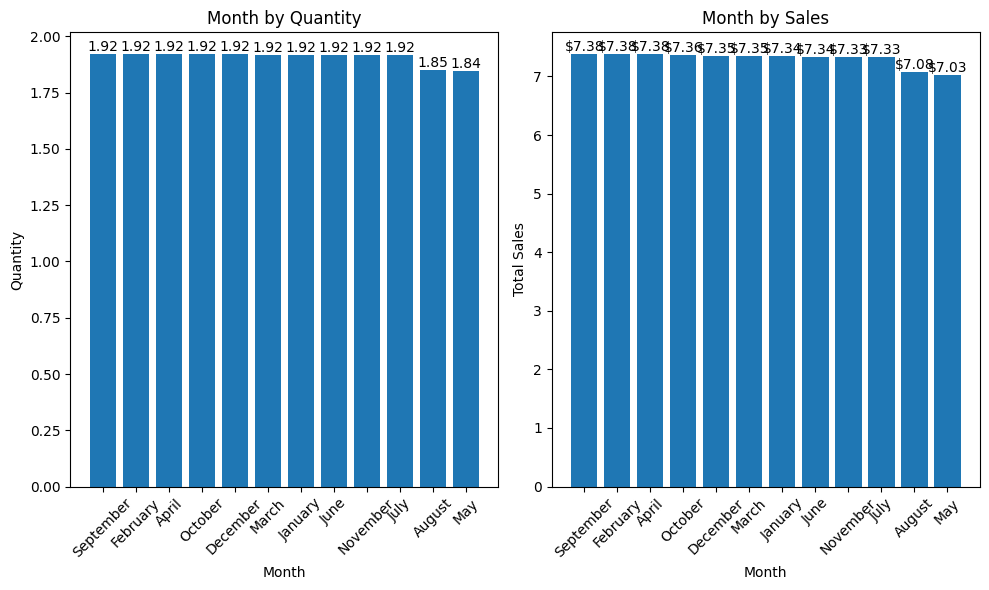

In [50]:
df1 = df.groupby(by='month').agg("mean")[['prod_qty']].reset_index().sort_values(by='prod_qty', ascending=False)
df2 = df.groupby(by='month').agg("mean")[['tot_sales']].reset_index().sort_values(by='tot_sales', ascending=False)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.bar(df1['month'], df1['prod_qty'])
plt.title('Month by Quantity')
plt.xlabel('Month')
plt.ylabel('Quantity')

# Adding data labels for prod_qty
for i, value in enumerate(df1['prod_qty']):
    plt.text(i, value, f"{value:.2f}", ha='center', va='bottom')

plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(df1['month'], df2['tot_sales'])
plt.title('Month by Sales')
plt.xlabel('Month')
plt.ylabel('Total Sales')

# Adding data labels for tot_sales
for i, value in enumerate(df2['tot_sales']):
    plt.text(i, value, f"${value:.2f}", ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

####  Months don't also vary very much in regards to the product quantity and the total sales

### Is there a relationship between product quantity and total sales?

In [51]:
# get the correlation coefficient between prod_qty and tot_sales
x = df['prod_qty']
y= df['tot_sales']
corr_coef = np.corrcoef(x, y)[0, 1]

corr_coef

0.71530757434961

#### There's an obvious positive relationship between product quantity and total sales because total sales is calculated from the product of product quantity and unit price of the product

## Handling the outliers

### For prod_qty column

In [52]:
data = df.copy()

# Calculate the Z-score for the 'Value' column
data['Z-score'] = stats.zscore(data['prod_qty'])

# Define the Z-score threshold for outlier detection
zscore_threshold = 3

# Identify outliers
outliers = data[data['Z-score'].abs() > zscore_threshold]

# Handle outliers (e.g., remove outliers or replace with a specific value)
data_cleaned = data[data['Z-score'].abs() <= zscore_threshold]

outlier_count = outliers.shape[0]
# Print the count of identified outliers
print("Count of identified outliers:", outlier_count)

clean_data_count = data_cleaned.shape[0]
# Print the count of the cleaned dataset without outliers
print("Count of cleaned dataset:", clean_data_count)

percentage = (outliers.shape[0]/data.shape[0]) * 100
# print the percentage of outlier data
print("Count of percentage of outliers:", str(percentage) +'%')

Count of identified outliers: 849
Count of cleaned dataset: 263986
Count of percentage of outliers: 0.3205769630147073%


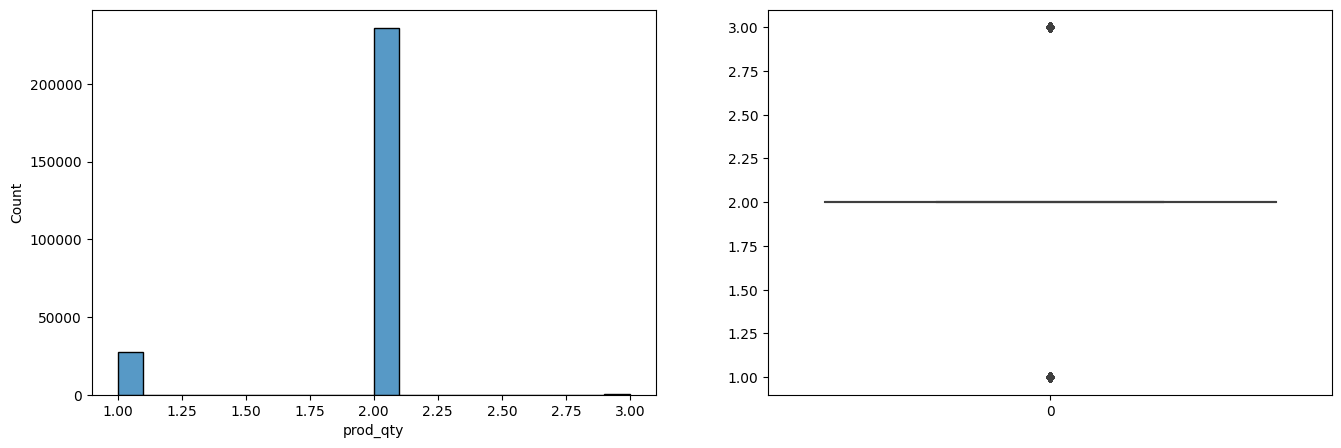

In [53]:
# distribution after capping
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.histplot(data_cleaned['prod_qty'])
plt.subplot(1,2,2)
sns.boxplot(data_cleaned['prod_qty'])
plt.show()

#### In this case, deleting the outliers seemed like a better alternatuve to handling the outliers especially since most of the outliers are not upto 1% of the whole dataset. Meanwhile in the distribution, you'll notice that there are still few outliers. However, we'll be leaving it this way because if we work on it further, all values would turn to 2 which coudl cause bias in the analysis. 

### For tot_sales column

#### I'll be using the cleaned data from the dataset birthed when I handled the outliers in prod_qty column. 

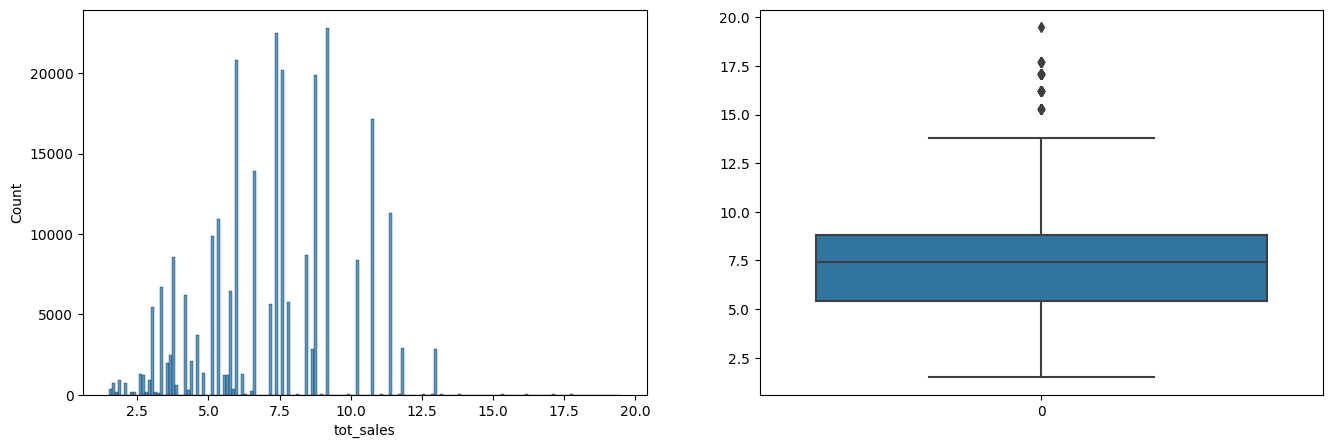

In [54]:
# distribution after capping
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.histplot(data_cleaned['tot_sales'])
plt.subplot(1,2,2)
sns.boxplot(data_cleaned['tot_sales'])
plt.show()

#### The outliers in the tot_sales are not so extreme in the cleaned data like that of the prod_qty so we'll be using the winsorization method to handle the outliers. 

In [55]:
# cap the outliers by copying the data into a new dataframe before performing the capping

percentile25 = data_cleaned['tot_sales'].quantile(0.25)
percentile75 = data_cleaned['tot_sales'].quantile(0.75)
iqr = percentile75 - percentile25

upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

new_df_cap = data_cleaned.copy()
new_df_cap['tot_sales'] = np.where(
    new_df_cap['tot_sales'] > upper_limit,
    upper_limit,
    np.where(
        new_df_cap['tot_sales'] < lower_limit,
        lower_limit,
        new_df_cap['tot_sales']
    )
)

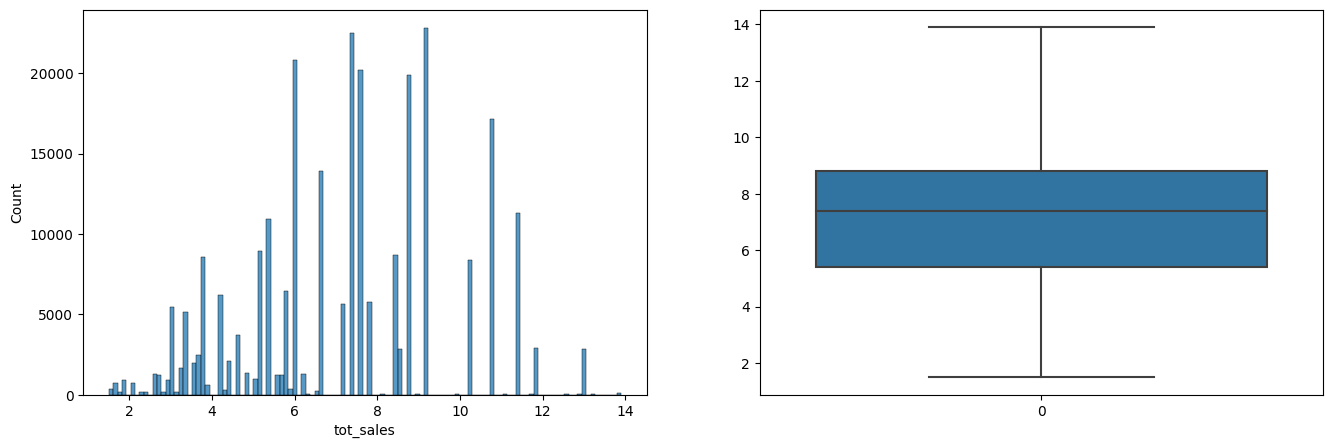

In [56]:
# show distribution after capping

plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.histplot(new_df_cap['tot_sales'])
plt.subplot(1,2,2)
sns.boxplot(new_df_cap['tot_sales'])
plt.show()

In [57]:
# set the cleaned data to the original dataframe
df = new_df_cap

del new_df_cap

#### For pack_size_in_g column

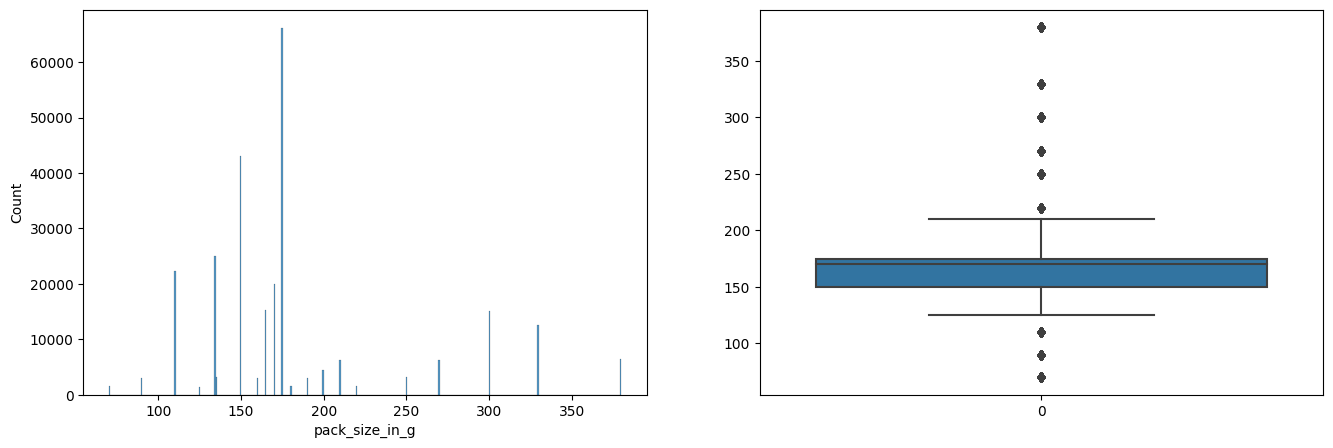

In [58]:
# distribution after capping
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.histplot(df['pack_size_in_g'])
plt.subplot(1,2,2)
sns.boxplot(df['pack_size_in_g'])
plt.show()

In [59]:
# cap the outliers by copying the data into a new dataframe before performing the capping

percentile25 = df['pack_size_in_g'].quantile(0.25)
percentile75 = df['pack_size_in_g'].quantile(0.75)
iqr = percentile75 - percentile25

upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

new_df_cap = df.copy()
new_df_cap['pack_size_in_g'] = np.where(
    new_df_cap['pack_size_in_g'] > upper_limit,
    upper_limit,
    np.where(
        new_df_cap['pack_size_in_g'] < lower_limit,
        lower_limit,
        new_df_cap['pack_size_in_g']
    )
)

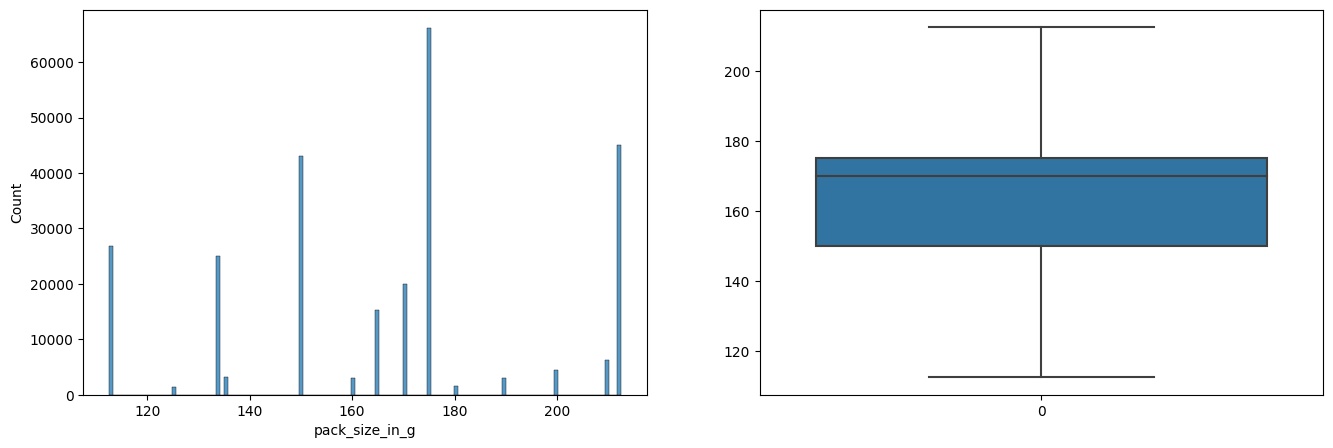

In [60]:
# show distribution after capping

plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.histplot(new_df_cap['pack_size_in_g'])
plt.subplot(1,2,2)
sns.boxplot(new_df_cap['pack_size_in_g'])
plt.show()

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263986 entries, 0 to 264834
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   date              263986 non-null  datetime64[ns]
 1   lifestage         263986 non-null  object        
 2   premium_customer  263986 non-null  object        
 3   loyalty_card_num  263986 non-null  object        
 4   store_nbr         263986 non-null  object        
 5   prod_name         263986 non-null  object        
 6   pack_size_in_g    263986 non-null  int32         
 7   brand_name        263986 non-null  object        
 8   prod_qty          263986 non-null  int64         
 9   tot_sales         263986 non-null  float64       
 10  day               263986 non-null  object        
 11  month             263986 non-null  object        
 12  Z-score           263986 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1), objec

## Segmentation Analysis

#### The dataset contains mixed data comprising of categorical and numerical data. Hence, I'll be using KPrototypes for the Customer Segmentation

In [62]:
# select the variables into a different dataframe
data = df[['lifestage', 'premium_customer', 'store_nbr', 'brand_name', 'pack_size_in_g', 'prod_qty', 'tot_sales', 'day']]

In [63]:
# convert it to an array
data_array = data.values
data_array

array([['YOUNG SINGLES/COUPLES', 'Premium', '1', ..., 2, 6.0,
        'Wednesday'],
       ['YOUNG SINGLES/COUPLES', 'Mainstream', '1', ..., 1, 2.7,
        'Sunday'],
       ['YOUNG FAMILIES', 'Budget', '1', ..., 1, 3.6, 'Thursday'],
       ...,
       ['OLDER FAMILIES', 'Budget', '88', ..., 2, 8.4, 'Wednesday'],
       ['OLDER FAMILIES', 'Budget', '88', ..., 2, 10.2, 'Saturday'],
       ['YOUNG SINGLES/COUPLES', 'Mainstream', '88', ..., 2, 11.4,
        'Friday']], dtype=object)

In [64]:
# convert the prod_qty and pack_size_in_g to float

data_array[:, 4] = data_array[:, 4].astype(float)
data_array[:, 5] = data_array[:, 5].astype(float)
data_array

array([['YOUNG SINGLES/COUPLES', 'Premium', '1', ..., 2.0, 6.0,
        'Wednesday'],
       ['YOUNG SINGLES/COUPLES', 'Mainstream', '1', ..., 1.0, 2.7,
        'Sunday'],
       ['YOUNG FAMILIES', 'Budget', '1', ..., 1.0, 3.6, 'Thursday'],
       ...,
       ['OLDER FAMILIES', 'Budget', '88', ..., 2.0, 8.4, 'Wednesday'],
       ['OLDER FAMILIES', 'Budget', '88', ..., 2.0, 10.2, 'Saturday'],
       ['YOUNG SINGLES/COUPLES', 'Mainstream', '88', ..., 2.0, 11.4,
        'Friday']], dtype=object)

In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263986 entries, 0 to 264834
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   lifestage         263986 non-null  object 
 1   premium_customer  263986 non-null  object 
 2   store_nbr         263986 non-null  object 
 3   brand_name        263986 non-null  object 
 4   pack_size_in_g    263986 non-null  int32  
 5   prod_qty          263986 non-null  int64  
 6   tot_sales         263986 non-null  float64
 7   day               263986 non-null  object 
dtypes: float64(1), int32(1), int64(1), object(5)
memory usage: 25.2+ MB


#### We'll be using 3 clusters for the data

In [66]:
kproto = KPrototypes(n_clusters=3, verbose=2, max_iter=20)
clusters = kproto.fit_predict(data_array, categorical= [0, 1, 2, 3, 7])

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/20, moves: 83414, ncost: 131373876.71905114
Run: 1, iteration: 2/20, moves: 5687, ncost: 124979761.59139618
Run: 1, iteration: 3/20, moves: 0, ncost: 124979761.59139618
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/20, moves: 95153, ncost: 160369541.2590945
Run: 2, iteration: 2/20, moves: 37298, ncost: 125181095.48917651
Run: 2, iteration: 3/20, moves: 81, ncost: 125181023.02654211
Run: 2, iteration: 4/20, moves: 0, ncost: 125181023.02654211
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/20, moves: 104887, ncost: 634109389.6768818
Run: 3, iteration: 2/20, moves: 126676, ncost: 161616536.67536467
Run: 3, iteration: 3/20, moves: 38018, ncost: 125181255.59361202
Run: 3, iteration: 4/20, moves: 145, ncost: 12

In [67]:
print(kproto.cluster_centroids_)

[['176.29070641800047' '1.8941488526594998' '6.830846396020754'
  'OLDER SINGLES/COUPLES' 'Mainstream' '93' 'Kettle' 'Sunday']
 ['312.4545245222197' '1.9006216900759842' '9.301675109352596'
  'OLDER SINGLES/COUPLES' 'Mainstream' '226' 'Smiths' 'Wednesday']
 ['133.14103298270996' '1.899916613922461' '6.913316656118845'
  'OLDER SINGLES/COUPLES' 'Mainstream' '226' 'Pringles' 'Sunday']]


In [68]:
cluster_dict = []
for c in clusters:
    cluster_dict.append(c)

In [69]:
cluster_dict

[0,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 1,
 0,
 1,
 0,
 1,
 2,
 0,
 1,
 2,
 2,
 0,
 0,
 2,
 2,
 0,
 2,
 0,
 2,
 1,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 1,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 2,
 2,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 1,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 1,
 2,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 0,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 1,
 1,
 2,
 0,
 2,
 1,
 0,
 1,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 1,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 1,
 1,
 0,
 0,
 2,
 0,
 2,
 1,
 2,
 1,
 0,
 1,
 0,
 1,
 2,
 0,
 2,
 1,
 1,
 0,
 2,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 0,
 1,
 2,
 0,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 2,
 2,
 0,
 2,
 0,
 0,
 2,
 2,
 2,
 1,
 0,
 2,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 2,
 0,
 2,
 1,
 2,
 2,
 2,
 0,
 0,
 1,
 0,
 2,
 1,
 0,
 2,
 0,
 2,
 0,
 0,
 2,
 0,
 1,
 0,
 2,
 1,


In [70]:
df['cluster'] = cluster_dict

In [71]:
df

,date,lifestage,premium_customer,loyalty_card_num,store_nbr,prod_name,pack_size_in_g,brand_name,prod_qty,tot_sales,day,month,Z-score,cluster
0,2018-10-17,YOUNG SINGLES/COUPLES,Premium,1000,1,Natural Chip Compny SeaSalt175g,175,Natural,2,6.0,Wednesday,October,0.144009,0
1,2018-09-16,YOUNG SINGLES/COUPLES,Mainstream,1002,1,Red Rock Deli Chikn&Garlic Aioli 150g,150,Red,1,2.7,Sunday,September,-1.409621,2
2,2019-03-07,YOUNG FAMILIES,Budget,1003,1,Grain Waves Sour Cream&Chives 210G,210,Grain,1,3.6,Thursday,March,-1.409621,0
3,2019-03-08,YOUNG FAMILIES,Budget,1003,1,Natural ChipCo Hony Soy Chckn175g,175,Natural,1,3.0,Friday,March,-1.409621,0
4,2018-11-02,OLDER SINGLES/COUPLES,Mainstream,1004,1,WW Original Stacked Chips 160g,160,WW,1,1.9,Friday,November,-1.409621,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264830,2018-12-08,YOUNG FAMILIES,Mainstream,2370701,88,Grain Waves Sweet Chilli 210g,210,Grain,2,7.2,Saturday,December,0.144009,0
264831,2018-10-01,YOUNG FAMILIES,Premium,2370751,88,Kettle Tortilla ChpsFeta&Garlic 150g,150,Kettle,2,9.2,Monday,October,0.144009,2
264832,2018-10-24,OLDER FAMILIES,Budget,2370961,88,Tyrrells Crisps Lightly Salted 165g,165,Tyrrells,2,8.4,Wednesday,October,0.144009,0
264833,2018-10-27,OLDER FAMILIES,Budget,2370961,88,Old El Paso Salsa Dip Chnky Tom Ht300g,300,Old,2,10.2,Saturday,October,0.144009,1


#### Let's filter the dataset by the clusters and see if we can find any patterns

In [74]:
df.groupby(['cluster']).mean().round()

C:\Users\USER\AppData\Local\Temp\ipykernel_6672\3175518193.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(['cluster']).mean().round()


,pack_size_in_g,prod_qty,tot_sales,Z-score
cluster,,,,
0,176.0,2.0,7.0,-0.0
1,312.0,2.0,9.0,-0.0
2,133.0,2.0,7.0,-0.0


#### The three clusters are dissimilar in terms of the pack_size_in_g. The average of the pack size for clusters 0, 1, and 2 are 176, 312 and 133 respectively. This could mean that customers in cluster 2 buy products of the lowest pack size, cluster 1 buy pack sizes that are in between high and low while cluster 1 purchases products with high pack sizes. In terms of prod_qty, they are not different. However, in terms of tot_sales, it seems like cluster 1 spends more money probably because they buy products with the highest pack sizes

In [77]:
df.groupby(['cluster']).min().round()

,date,lifestage,premium_customer,loyalty_card_num,store_nbr,prod_name,pack_size_in_g,brand_name,prod_qty,tot_sales,day,month,Z-score
cluster,,,,,,,,,,,,,
0,2018-07-01,MIDAGE SINGLES/COUPLES,Budget,1000,1,Burger Rings 220g,160,Burger,1,2.0,Friday,April,-1.0
1,2018-07-01,MIDAGE SINGLES/COUPLES,Budget,100000,1,Cheezels Cheese 330g,250,Cheezels,1,2.0,Friday,April,-1.0
2,2018-07-01,MIDAGE SINGLES/COUPLES,Budget,10000,1,Cheezels Cheese Box 125g,70,Cheezels,1,2.0,Friday,April,-1.0


#### The minimum pack sizes that each cluster purchase are 160, 250, and 70 for clusters 0, 1, and 2 respectively. This is still in line with the hypotheses derived from the average pack sizes. The tot_sales and prod_qty are not different for the three clusters. 

In [76]:
df.groupby(['cluster']).max().round()

,date,lifestage,premium_customer,loyalty_card_num,store_nbr,prod_name,pack_size_in_g,brand_name,prod_qty,tot_sales,day,month,Z-score
cluster,,,,,,,,,,,,,
0,2019-06-30,YOUNG SINGLES/COUPLES,Premium,99501,99,Woolworths Cheese Rings 190g,220,Woolworths,3,14.0,Wednesday,September,2.0
1,2019-06-30,YOUNG SINGLES/COUPLES,Premium,99396,99,Woolworths Mild Salsa 300g,380,Woolworths,3,14.0,Wednesday,September,2.0
2,2019-06-30,YOUNG SINGLES/COUPLES,Premium,99465,99,Sunbites Whlegrn Crisps Frch/Onin 90g,150,Sunbites,3,14.0,Wednesday,September,2.0


#### The maximum pack sizes for clusters 0, 1, and 2 are 220, 380 and 150 respecively. prod_qty and tot_sales are not different in this case too. This leads us to this conclusion regarding the pack sizes range for the respective clusters

- Cluster 0: 160g - 220g. They buy pack sizes on an average. 

- Cluster 1: 250g - 380g. They buy the highest pack sizes. Hence, they spend more money too

- Cluster 2: 70g - 150g. They buy the lowest pack sizes. 

In [78]:
#stats of categorical data by mode
df.groupby(['cluster']).agg(lambda x: pd.Series.mode(x).iat[0])[['lifestage','premium_customer','store_nbr','brand_name',\
                                                                    'day']]

,lifestage,premium_customer,store_nbr,brand_name,day
cluster,,,,,
0,OLDER SINGLES/COUPLES,Mainstream,93,Kettle,Sunday
1,OLDER SINGLES/COUPLES,Mainstream,226,Smiths,Wednesday
2,OLDER SINGLES/COUPLES,Mainstream,226,Pringles,Sunday


#### The mode of all categorical features are different for the store_nbr, brand_name, and day. 

#### Customers in cluster 0, 1, and 2 mostly patronize stores 93, 226 and 226 respectively. 

#### Customers in cluster 0, 1, and 2 mostly buy branded products of Kettle, Smiths, and Pringles respectively. 

#### Customers in cluster 0, 1, and 2 patronize the super market on Sunday, Wednesday and Sunday respectively. 

#### Before we make our conclusions and recommendations, I'll be writing the file to a csv file

In [82]:
# Count the number of customers in each cluster

cluster_counts = df['cluster'].value_counts()
print(cluster_counts)

0    121019
2     99537
1     43430
Name: cluster, dtype: int64


#### Most customers fall under cluster 0 (the medium ended customers) while cluster 1 (the high-ended customers) contain the least number of customers

In [80]:
df.to_csv('customer_sales.csv', index=False)

## Conclusion

- There are 3 major clusters of customers in the supermarket. 

- Customers in cluster 2 are the low-ended customers who buy products of the least pack sizes (70g - 150g)

- Customers in cluster 0 are the medium-ended customers who buy products of pack sizes on average (160g - 220g)

- Customers in cluster 1 are the high-ended customers who buy products of the large pack sizes (250g - 380g)

- Customers in cluster 0 are the majority of the supermarket while cluster 1 are the minority

- Customers in cluster 1 spend the highest amount on average

- Customers in cluster 0 mostly patronize store 93

- Customers in cluster 1 and 2 mostly patronize store 226

- Customers in cluster 0 usually buy Kettle branded products

- Customers in cluster 1 usually buy Smiths branded products

- Customers in cluster 2 usually buy pringles branded products

- Customers in cluster 1 usually visit the stores on Wednesday

- Customers in cluster 0 and 2 usually visit the stores on Sunday

Let's give these clusters a name, shall we?

- Cluster 0 - Size Savvy Shoppers
- Cluster 1 - Portable Pleasure Hunters
- Cluster 2 - Big Bite Buyers

## Recommendations for Julia

- Develop targeted marketing campaigns for each customer cluster based on their preferences and buying patterns. Tailor your messaging and promotions to appeal to each cluster's specific needs and desires.

- Optimize your product assortment based on the preferences of each customer cluster. Stock a wide variety of pack sizes for each product category, with a focus on the preferred pack sizes and brands of each cluster.

- Enhance the store layout and product placement to cater to the preferences of each cluster. Place products preferred by each cluster in prominent locations within the store especially the most visited, making them easily accessible and visible.

- Analyze the performance of store 93, which attracts most customers from cluster 0, and identify ways to further optimize its offerings to cater to their needs. Similarly, assess the performance of store 226 and ensure it is well-stocked with the preferred products of customers from clusters 1 and 2.

- Collaborate with Kettle, Smiths, and Pringles (the preferred brands for each cluster) to develop joint marketing initiatives and promotions that target their respective customer segments.

- Train staff to identify opportunities for cross-selling and upselling based on the preferences of each cluster. Recommend complementary products or larger pack sizes to customers during their shopping experience.

- Implement personalized marketing strategies, such as targeted email campaigns or personalized product recommendations, based on the preferences and purchasing history of each cluster.